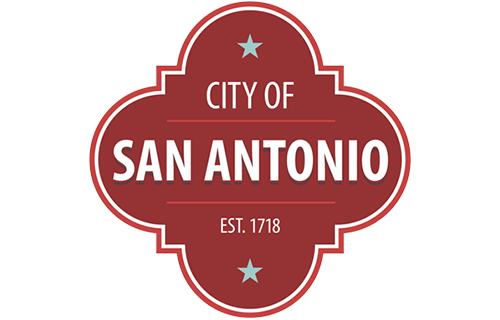

# Predicting Completion Time for San Antonio 311 Service Reports
>Stephanie N. Jones<br>
>Individual Project<br>
>Codeup | Data Science, Hopper Cohort<br>
>Monday, Jan. 24, 2022<br>

# Executive Summary
### About City of San Antonio (COSA) 311
311 is the City of San Antonio (COSA)’s non-emergency service contact line. It connected Bexar county residents with specially- trained customer service representatives who can help with city requests such as: garbage/recycle information, potholes, stray animals, code enforcement concerns, graffiti on private property, or other city requests.
### Project Information
For this project I am looking at data from the COSA website, looking to predict the length of time it takes to close a given 311 request.
### Project Goal
My goal is to generate insights from the exploratory data analysis and model predictions that will allow end users such as city leaders and COSA managers close the gap and complete more 311 customer service times on or before their scheduled SLA date. 
<br><br>
With these insights I will build a machine learning model using Linear Regression to predict the time it takes to close a 311 service request, measured by the target variable `days_to_close`. 
### Initial Thoughts and Questions
I think that location with higher median incomes have better service reponse times and more instances of cases closing by their SLA date. Some initial questions I had of the data:
1. Does a report's originating location affect the time it takes to close?
2. What impacts whether a report closes on time more, where it originates or the location of the issue being reported?

# 00_plan
>I used a [Trello Board](https://trello.com/b/UMS0I3iS) for planning.

I was able to find a dataset on the [COSA website](https://data.sanantonio.gov/dataset/service-calls/resource/20eb6d22-7eac-425a-85c1-fdb365fd3cd7) with COSA 311 reports from the last 365 days. I merged those reports with geographic and median income from [this website](https://www.zip-codes.com/city/tx-san-antonio.asp) and did a left join on the zip code columns.

# Data Dictionary
### target
Target | Dtype | Description
:--- | :--- | :---
`days_to_close` | datetime | the total time in days it took to close the case; feature engineered from `close_date` - `open_date`

### variables
Variable | Dtype |  Description
:--- | :--- | :---
`category` | object | top level 311 service request category
`case_open` | datetime | the date a case was submitted
`sla_due` | dtype | each service request `category` has a due date assigned to the request, based on the dept division `dept_div`
`dept` | object | the City deaprtment to whom the case is assigned
`dept_div` | object | the department division within the City deaprtment to whom the case is assigned
`council_distr` | object | The Council District number from where the issue was reported
`zip` | object | the zip code for the reported case/service requested
`population` | int | the population for the zip code for the reported case/service requested
`avg_inc` | float | the avergae income for the zip code for the reported case/service requested
`lat` | float | the latitude coordinate for the zip code for the reported case/service requested
`long` | float | the longitude coordinate for the zip code for the reported case/service requested

# 01_wrangle
To wrangle the data I completed the merge and looked at the distributions of each variable. I noticed there were a lot of outliers for most and decided if I had time I would come back and remove those. Below you will find a list of columns I updated dtypes for and planned to explore.

In [1]:
import wrangle as w
import explore as e
import model as m

311_service_data.csv read complete.
There are 521590 rows and 17 columns in 311_service_data.csv.

med_incomebyzip.csv read complete.
There are 60 rows and 7 columns in med_incomebyzip.csv.

Left DF Zip Column Ready for Merge.
Right DF Zip Column Ready for Merge.
DFs Merged.
There are 436576 rows and 23 columns in the merged df.



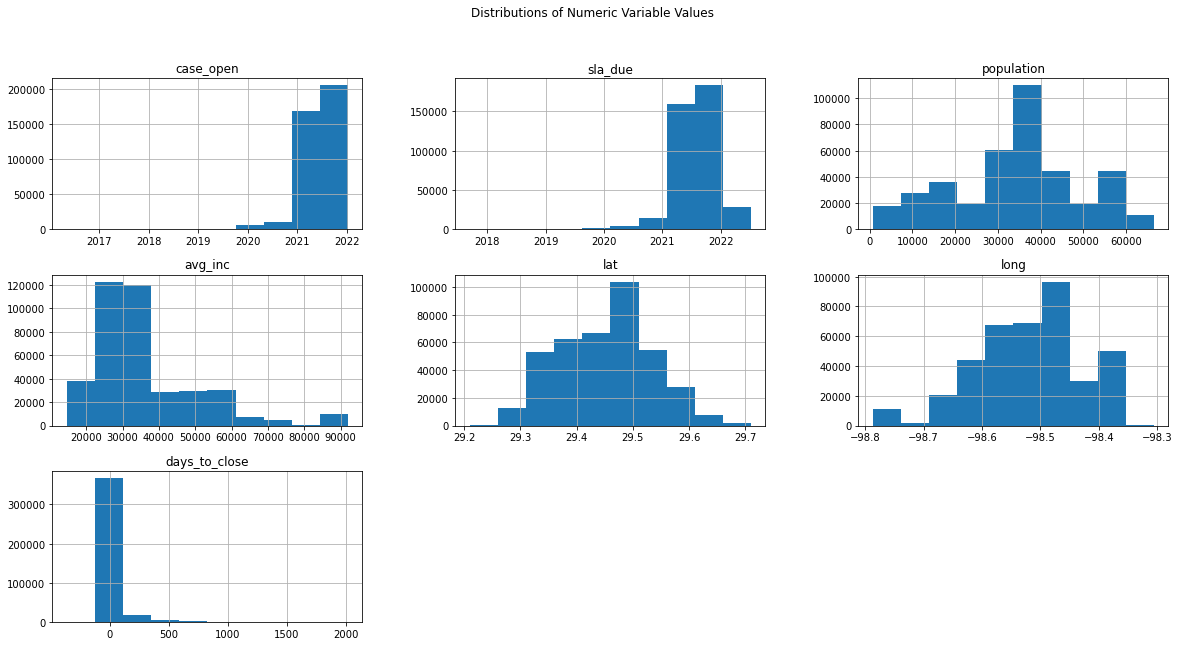

Object List:
['category', 'dept', 'dept_div', 'sourceid', 'council_distr', 'zip']

Integer List:
['population', 'days_to_close']

Bool List:
['sla_late']

Float List:
['avg_inc', 'lat', 'long']

Dates List:
['case_open', 'sla_due']

There are 390069 rows and 14 columns in the cleaned df.
DataFrame is cleaned and ready for splitting.
Data has been split.
train -> (218438, 14)
validate -> (93617, 14)
test -> (78014, 14)



In [3]:
train, validate, test = e.wrangle_data('311_service_data.csv', 'med_incomebyzip.csv')

# 02_explore

### First I wanted to see the correlations between the continuous variables and the target. 
I did this looking at a heatmap and running correlation tests with each of the two

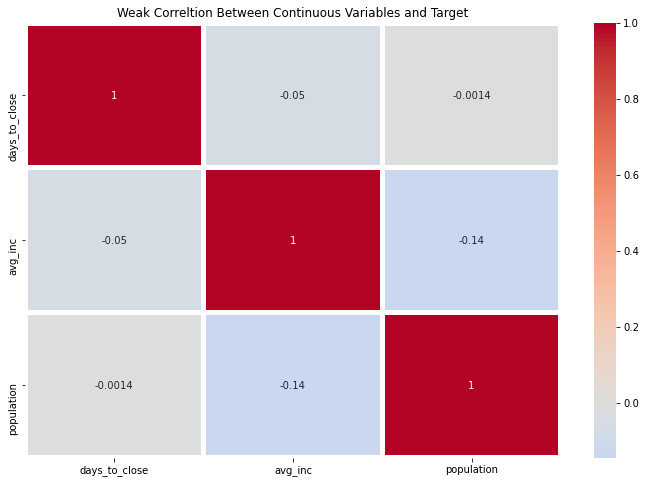

Looking at days_to_close and avg_inc
The r-value is: 0.02
The p-value is: 5.598995325179636e-28
There is 0.0% chance that we see these results by chance.
--------------------------

Looking at days_to_close and population:
The r-value or correlation coefficient is: 0.01
The p-value is: 6.708030050925223e-09
There is 0.0% chance that we see these results by chance.
--------------------------



In [4]:
e.continuous_heatmap(train)

### Next i wanted to look at the breakout of some of the categorical variables. 

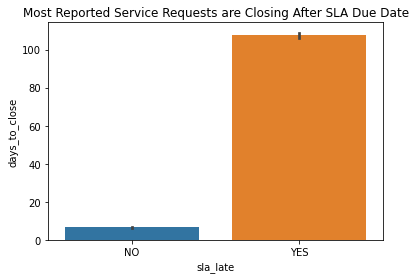

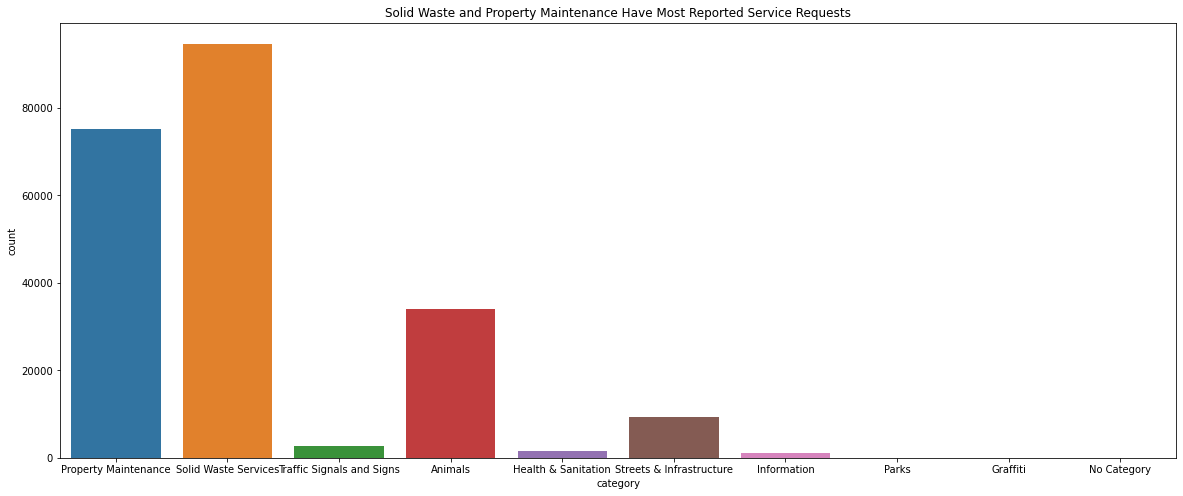

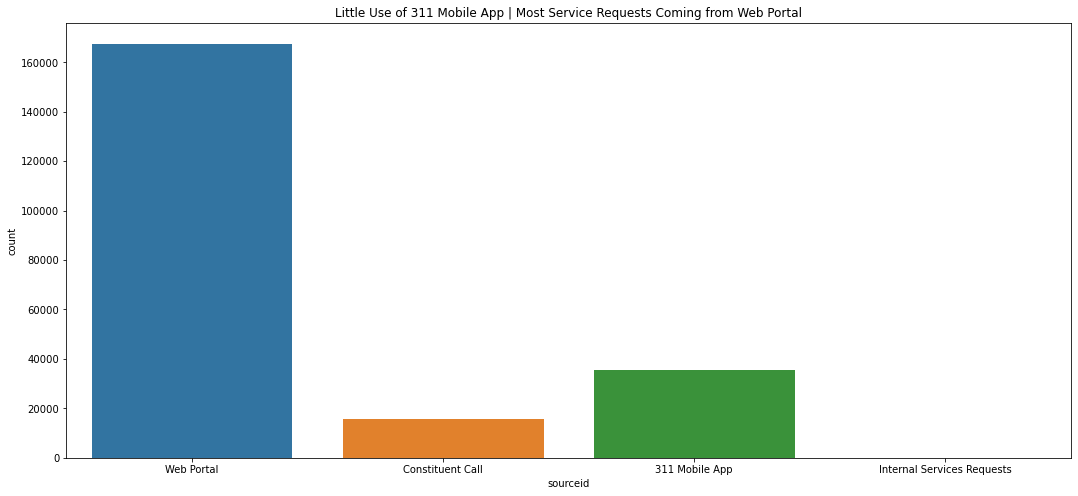

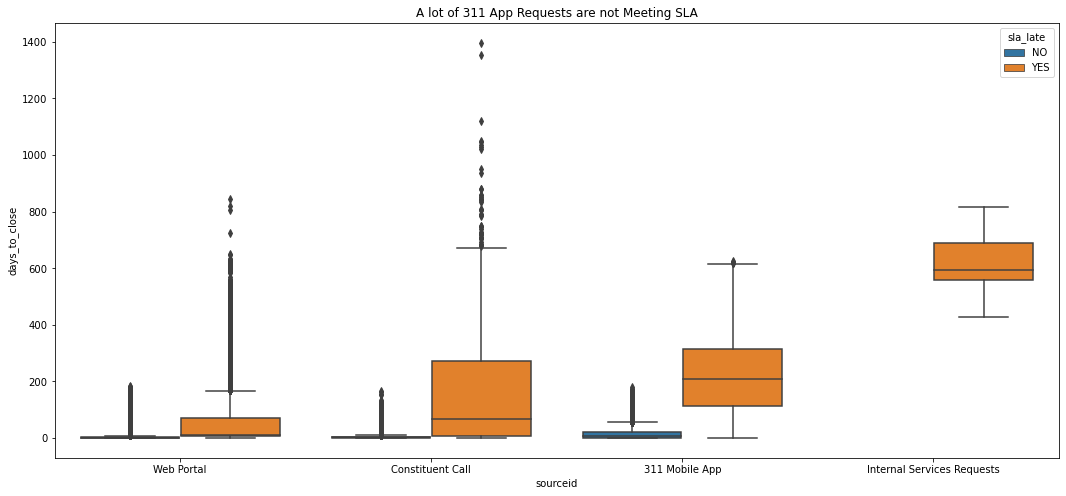

In [5]:
e.explore(train)

## Explore Takeaways

- There are a lot of Waste Collection reports. Graffiti has hardly any reports.

- There is also x1 report that does not have a category. I am going to look at other similar reports and see if I can fill in the category value. 

- Almost all of the reports are generated through the web portal. I thought the 311 mobile app would have the most reports but it looks like people are not using it very much.
- I would like to see how the cases reported by the mobile app vs those reported through web portal are closing, measured by the percentage of them are meeting their sla due date

- There are only x10 city council districts, but x11 values for this field. One of the districts is 0, so I think you have to add one to each value to get the county district. Without additional information I am not sure what the 11th district value would be? Possibly an unknown value, where the reporting district was not know. I will not this in the final report conclusions with a note that I have a city county district group, but I need to know what city council district that actually responds to because the numbers may be off. 

- Per [zip-codes.com](https://www.zip-codes.com/city/tx-san-antonio.asp) San Antonio has x85 zip codes. There are 60 zip codes represented in this data. Though now all, I am able to look at over half. 

- Most of the case open and sla due dates are from the past 2 years. 

- Most of the cases that were closed as of the report date met their sla due date. 

- The populations by zip code are mostly normally distributed. 

- The average income per district is left skewed. 

- The days to close target variable is heavily left skewed. There are x12 reports with negative values. I am not sure if this information was miskeyed or if it means something else. Since it is such a small percentage of the data I am going to filter out these reports in the train, validate, and test data. 

# 03_model

### For modeling I used the following categorical features. I used dummy variables for them for the model
- `sourceid`
- `category`
- `council_distr`

311_service_data.csv read complete.
There are 521590 rows and 17 columns in 311_service_data.csv.

med_incomebyzip.csv read complete.
There are 60 rows and 7 columns in med_incomebyzip.csv.

Left DF Zip Column Ready for Merge.
Right DF Zip Column Ready for Merge.
DFs Merged.
There are 436576 rows and 23 columns in the merged df.



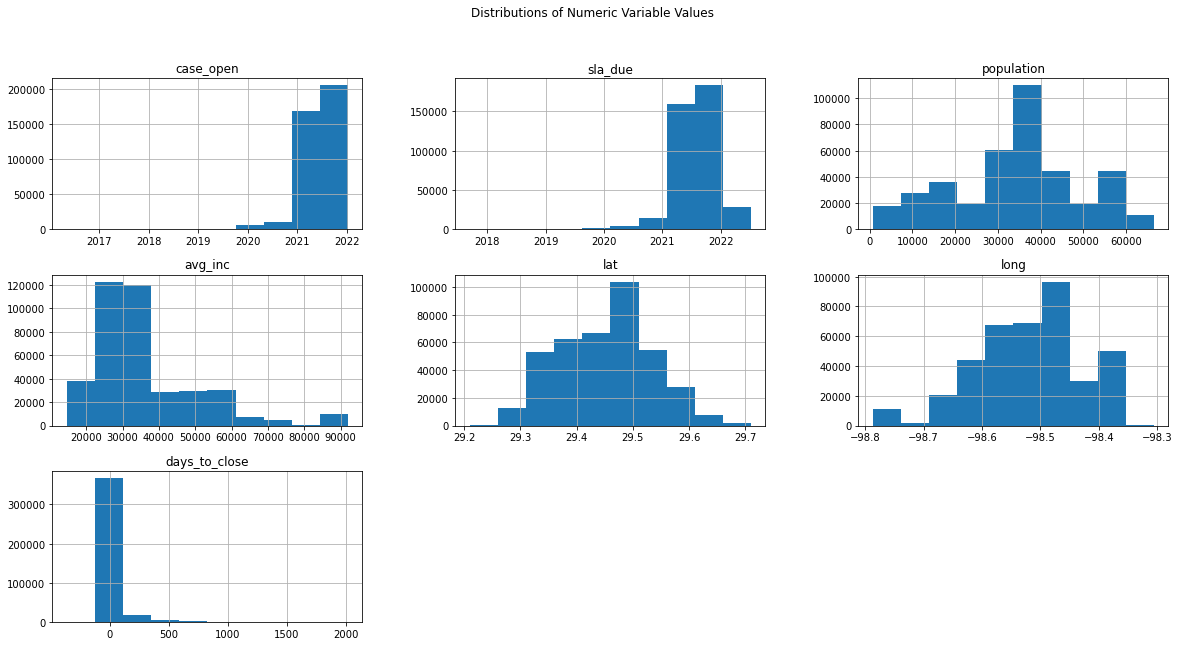

Object List:
['category', 'dept', 'dept_div', 'sourceid', 'council_distr', 'zip']

Integer List:
['population', 'days_to_close']

Bool List:
['sla_late']

Float List:
['avg_inc', 'lat', 'long']

Dates List:
['case_open', 'sla_due']

There are 390069 rows and 14 columns in the cleaned df.
DataFrame is cleaned and ready for splitting.


In [6]:
X_train, y_train, y_train_df, X_validate, y_validate, y_validate_df, X_test, y_test, y_test_df = m.prep_modeling()

### Model Results
- both models beat baseline
- Model 1 | Linear Regression had the best in sample and out of sample performance

In [7]:
m.model(X_train, y_train, y_train_df, X_validate, y_validate, y_validate_df, X_test, y_test, y_test_df)

Baseline RMSE | Train, In Sample: 73.28706164144211

LinearRegression RMSE | Train, In Sample: 69.18626669833728
LinearRegression RMSE | Validate, Out of Sample: 69.99106083478921

LassoLars RMSE | Train, In Sample: 73.28706164144211
LassoLars RMSE | Validate, Out of Sample: 74.15328949807076

LinearRegression RMSE | Test 71.95494345453567
Difference between model prediction and baseline 1.3321181869064418




# 04_evaluate

>I used model 1 on the test data and it did not perform as well. It did beat the baseline by 1.3 days.

I created a model that could predict the `days_to_close` a 311 service request with a `RMSE` of about 72 days. 

# 05_conclusions

My model did not perform as great as I would have hoped. Given more time I think I would have go back and look at `sla_late` as a feature and try to predict whether a report will close on time using the same features.
### Recommendations
- I would recommend COSA look inspect their Waste Management city services and find out why it is taking so long to close those cases. They make up a majority of the 311 service requests and most of the cases that are not meeting sla on time.
- I would also recommend COSA looking at their 311 service app and figuring out why it is so underutilized and why so many of the cases reported from it are not closing by their sla due date.